# Harpy support for InstanSeg segmentation model

This notebook provides a minimal example to show how to run [Instanseg](https://github.com/instanseg/instanseg), a pytorch based cell and nucleus segmentation pipeline for fluorescent and brightfield microscopy images. More information here:

Goldsborough, T. et al. (2024) ‘A novel channel invariant architecture for the segmentation of cells and nuclei in multiplexed images using InstanSeg’. bioRxiv, p. 2024.09.04.611150. Available at: https://doi.org/10.1101/2024.09.04.611150.

## 1. Run Instanseg example code

This is a minimal example to show how to run the code and notebook provided in the [Instanseg](https://github.com/instanseg/instanseg/blob/main/notebooks/segmentation_minimal.ipynb) repository.


In [1]:
# make sure to install instanseg
# pip install git+https://github.com/instanseg/instanseg.git@main

In [2]:
%load_ext autoreload
%autoreload 2

from harpy.datasets.registry import get_ome_registry

registry=get_ome_registry( path = None )  # if path is None, example .tif will be downloaded in the default cache folder of your os.
path = registry.fetch("Vectra-QPTIFF/perkinelmer/PKI_fields/LuCa-7color_%5b13860,52919%5d_1x1component_data.tif")

/Users/arnedf/miniconda3/envs/harpy_instanseg/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
2025-01-21 10:40:11,693 - harpy.image._tiling - WARNING - 'jax' or 'basicpy' not installed, to use 'harpy.im.tiling_correction', please install these libraries.
2025-01-21 10:40:11,693 - harpy.image._tiling - WARNING - 'squidpy' not installed, to use 'harpy.im.tiling_correction' please install this library.
2025-01-21 10:40:11,695 - harpy.image.pixel_clustering._clustering - WARNING - 'flowsom' not installed, to use 'harpy.im.flowsom', please install this library (https://git@github.com/saeyslab/FlowSOM_Python).
2025-01-21 10:40:12,916 - harpy.table._enrichment - WARNING - 'squidpy' not installed, to use 'harpy

In [3]:
import os

import torch
from instanseg import InstanSeg

# Call the function to download and extract the models

instanseg_brightfield = InstanSeg("brightfield_nuclei", verbosity=1,  device="cpu")
instanseg_fluorescence = InstanSeg("fluorescence_nuclei_and_cells", verbosity=1 ,device="cpu")

# or load the model from a path
path_model = os.path.join( os.environ.get( "INSTANSEG_BIOIMAGEIO_PATH" ), "fluorescence_nuclei_and_cells/0.1.0/instanseg.pt" )
instanseg_fluorescence= torch.load( path_model )
instanseg_fluorescence=InstanSeg( model_type=instanseg_fluorescence, device="cpu" )

Model brightfield_nuclei version 0.1.0 already downloaded in /Users/arnedf/miniconda3/envs/harpy_instanseg/lib/python3.11/site-packages/instanseg/utils/../bioimageio_models/, loading
Model fluorescence_nuclei_and_cells version 0.1.0 already downloaded in /Users/arnedf/miniconda3/envs/harpy_instanseg/lib/python3.11/site-packages/instanseg/utils/../bioimageio_models/, loading


/var/folders/q5/7yhs0l6d0x771g7qdbhvkvmr0000gp/T/ipykernel_77991/2783818680.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  instanseg_fluorescence= torch.load( path_mod

Use instanseg to get the pixel size of the image

In [4]:
# we can also use instanseg to get the pixel size
image_array, pixel_size = instanseg_fluorescence.read_image(path)
print( f"Physical pixel size is {pixel_size} μm." )
print( f"image dimensions are (c,y,x): {image_array.shape}." )

Physical pixel size is 0.49799447890790055 μm.
image dimensions are (c,y,x): (1400, 1868, 8).


/Users/arnedf/miniconda3/envs/harpy_instanseg/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/arnedf/miniconda3/envs/harpy_instanseg/lib/python3.11/site-packages/torch/nn/modules/module.py:1747: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647038473/work/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  return forward_call(*args, **kwargs)


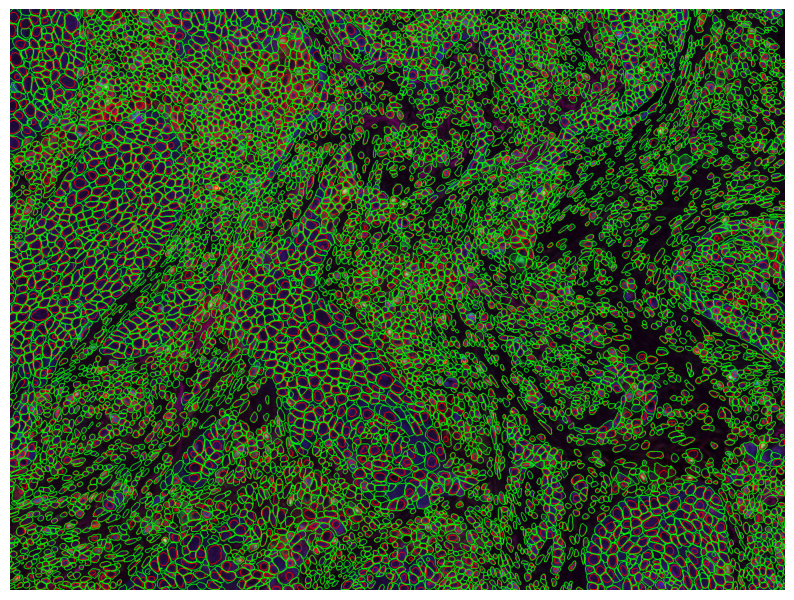

In [5]:
from instanseg.utils.utils import show_images

image_array, pixel_size = instanseg_fluorescence.read_image(path)

# transpose, so we have (c,y,x)
image_array = image_array.transpose( 2,0,1 )

labeled_output, image_tensor  = instanseg_fluorescence.eval_small_image(image_array, pixel_size, resolve_cell_and_nucleus=True, cleanup_fragments = True, target = "all_outputs",) # "all_outputs", "nuclei", or "cells".

display = instanseg_fluorescence.display(image_tensor, labeled_output)

show_images(display, colorbar=False)

## 2. Run InstanSeg with Harpy support

This is the same example, but using the Harpy library to run the code. The same model is loaded from the Instanseg repository and the code is executed on SpatialData objects.

- The same dataset is used, loaded in SpatialData using `harpy.datasets.vectra_example`.

- You can either run the segmentation model directly or via the Harpy segment function `harpy.im.segment`.


In [6]:
import harpy as hp

sdata=hp.datasets.vectra_example()
sdata

SpatialData object
└── Images
      └── 'image': DataArray[cyx] (8, 1400, 1868)
with coordinate systems:
    ▸ 'global', with elements:
        image (Images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.010349865436370627..1.087689350249904].


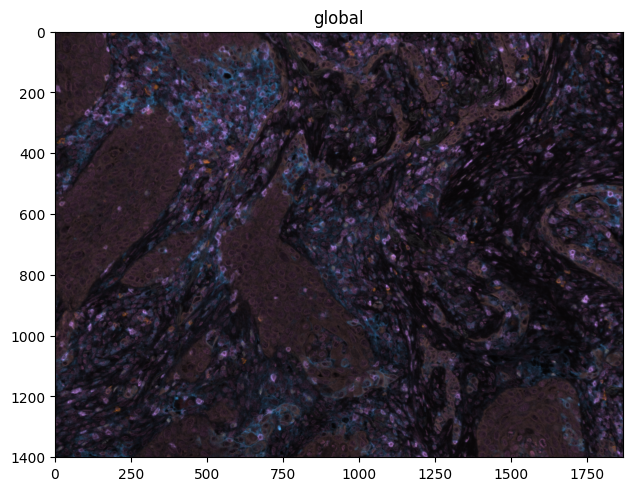

In [7]:
sdata.pl.render_images("image").pl.show()

### 2.1 Run just the InstanSeg model

The InstanSeg model is implementated as a Harpy segmentation model. It can be called like a function using the right arguments and segment the image.

A caveat is that Harpy segmentation models use data formatted as (z, y, x, c) as both input and output. The code above and the data in SpatialData objects is ordered as (c, y, x).

In [8]:
image_array=sdata[ "image" ].to_numpy().transpose( 1,2,0 )[None]
image_array.shape #-> (z,y,x,c)

(1, 1400, 1868, 8)

In [9]:
labels=hp.im.instanseg_callable( img=image_array, instanseg_model=instanseg_fluorescence, pixel_size=pixel_size, output="all_outputs", )
labels.shape # ->z,y,x,c

/Users/arnedf/miniconda3/envs/harpy_instanseg/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


(1, 1400, 1868, 2)

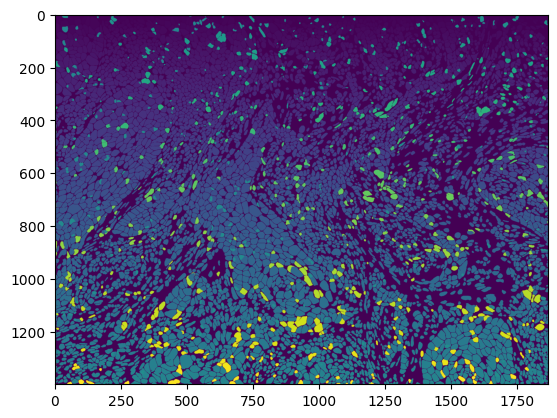

In [10]:
import matplotlib.pyplot as plt

plt.imshow(labels[0, ..., 1]) # plot whole cell masks

### 2.2 Run Instanseg using the Harpy segment function (recommended)

This is the most convenient way to run the model. It takes care of loading the model, running the segmentation on large images and returning the results in a SpatialData object as a Labels element. The segmentation process will be distributed using [`Dask`](https://www.dask.org/), ensuring the image is not fully loaded into memory and is instead processed in chunks.

We provide a path to the segmentation model (`instanseg_model` parameter), because a loaded `InstanSeg` model is of type `torch.jit.RecursiveScriptModule`, which is not serializable by `Dask`. Now each call to `hp.im.instanseg_callable` made by `hp.im.segment` (for each chunk), will load an `Instanseg` model, but because the model is small, this does not affect performance or increase memory usage.

In [11]:
import harpy as hp

sdata=hp.im.segment(
    sdata,
    img_layer="image",
    output_labels_layer=[ "labels_nuclei_harpy", "labels_cells_harpy" ],
    output_shapes_layer=[ "shapes_nuclei_harpy", "shapes_cells_harpy" ],
    labels_layer_align="labels_cells_harpy",
    chunks=(1000,1000),
    model=hp.im.instanseg_callable,
    # parameters passed to hp.im.instanseg_callable
    output="all_outputs",
    device="cpu",
    instanseg_model = path_model, # load it in every worker, because torchscript model is not serializable
    overwrite=True,
          )

/Users/arnedf/VIB/harpy/src/harpy/image/segmentation/segmentation_models/_instanseg.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  instanseg_model = torch.load(instans

/Users/arnedf/miniconda3/envs/harpy_instanseg/lib/python3.11/site-packages/torch/serialization.py:1328: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn(


Visualize the segmentation mask using `spatialdata-plot`.

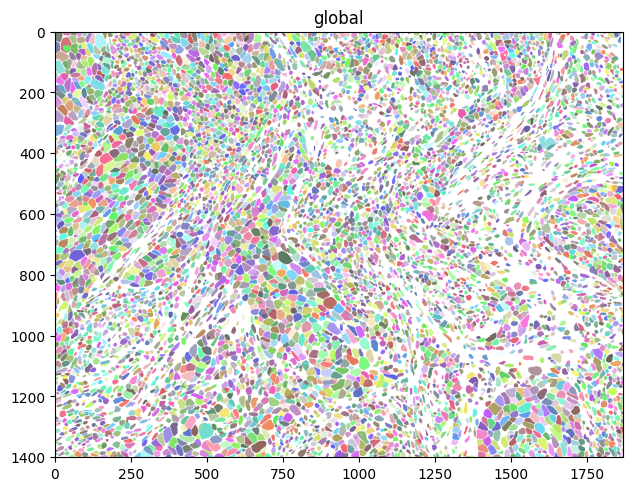

In [12]:
sdata.pl.render_labels( "labels_cells_harpy" ).pl.show()

Or visualize using `harpy`:

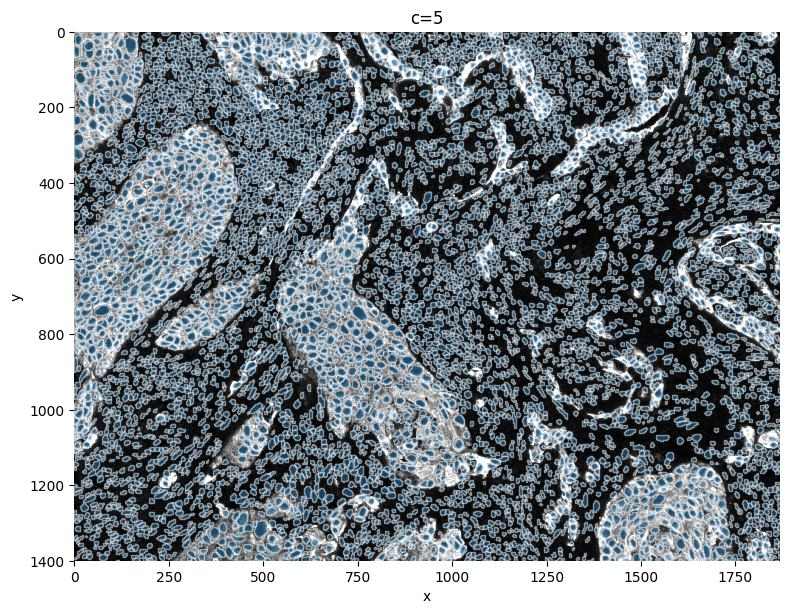

In [13]:
hp.pl.plot_shapes( sdata, img_layer="image", shapes_layer="shapes_nuclei_harpy", channel=5, figsize=(8,8) )

In [14]:
# interactive viewing with napari-spatialdata

#from napari_spatialdata import Interactive

#Interactive( sdata )